In [46]:
import sys, os, ndreg, skimage
import matplotlib.pyplot as plt
from matplotlib import cm
from ndreg import preprocessor, registerer
import SimpleITK as sitk
import numpy as np
from intern.remote.boss import BossRemote
from intern.resource.boss.resource import *
import missing_data as mdmask
import ingest_tif_stack as ingest

In [47]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

In [48]:
atlas_resolution = 50

rmt = BossRemote(cfg_file_or_dict='./intern.cfg')
atlas = ndreg.download_ara(rmt, atlas_resolution)
atlas_width, atlas_height, atlas_depth = atlas.GetSize()

In [50]:
# 1/2 mask
half_array = mdmask.gen_hemisphere_mask(atlas_depth, atlas_height, atlas_width)
half_mask = mdmask.convert_to_image(half_array.astype('uint16'))
half_mask.CopyInformation(atlas)
# 1/2 atlas
half_atlas = mdmask.mask_img(atlas, half_mask)

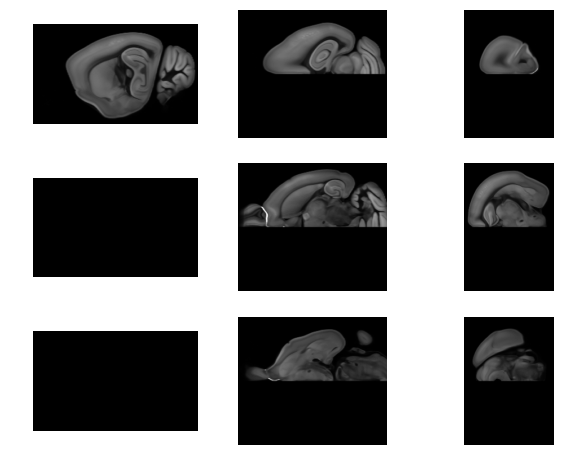

In [51]:
ndreg.imgShow(half_atlas)

# Registration

In [25]:
mm_to_um = 1000.0
resolution_atlas = 50
orientation_atlas = 'pir'
orientation_image = 'lps'

img = half_atlas
mask = half_mask

In [26]:
mask_dilation_radius = 10 # voxels
mask_bc = sitk.BinaryDilate(preprocessor.create_mask(img, use_triangle=True), mask_dilation_radius)
img_bc, bias = preprocessor.correct_bias_field(img, scale=0.25, spline_order=4, mask=mask,
                                         num_control_pts=[5,5,5],
                                         niters=[50, 50, 50, 50])

In [27]:
atlas_n = sitk.Normalize(atlas)
img_bc_n = sitk.Normalize(img_bc)

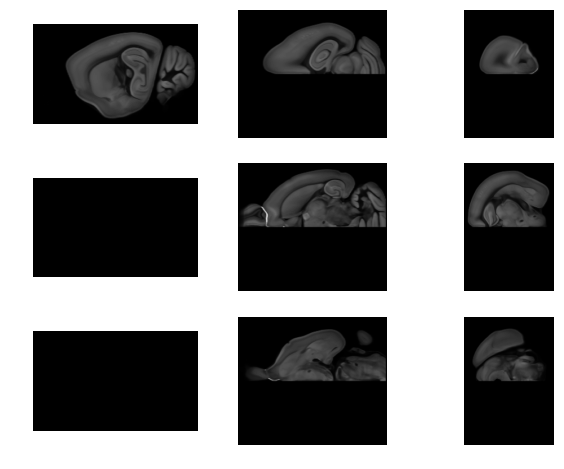

In [33]:
ndreg.imgShow(img_bc)

In [52]:
final_transform = register_rigid(atlas_n, 
                                    atlas_n,
                                    fixed_mask=mask,
                                    learning_rate=1e-1,
                                    grad_tol=4e-6,
                                    use_mi=False,
                                    iters=50,
                                    shrink_factors=[4,2,1],
                                    sigmas=[0.4, 0.2, 0.1],
                                    verbose=True)

In [53]:
atlas_rigid = registerer.resample(atlas, final_transform, img_bc, default_value=ndreg.imgPercentile(atlas,0.01))


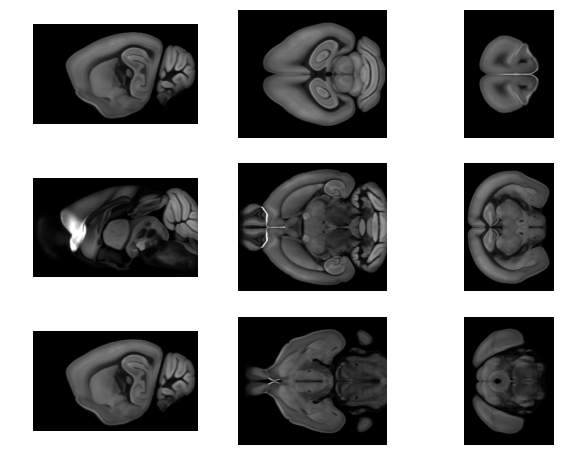

In [54]:
ndreg.imgShow(atlas_rigid)

In [29]:
final_transform = register_rigid(img_bc_n, 
                                    atlas_n,
                                    fixed_mask=mask,
                                    learning_rate=1e-1,
                                    grad_tol=4e-6,
                                    use_mi=False,
                                    iters=50,
                                    shrink_factors=[4,2,1],
                                    sigmas=[0.4, 0.2, 0.1],
                                    verbose=True)

In [30]:
atlas_rigid = registerer.resample(atlas, final_transform.GetInverse(), img_bc, default_value=ndreg.imgPercentile(atlas,0.01))


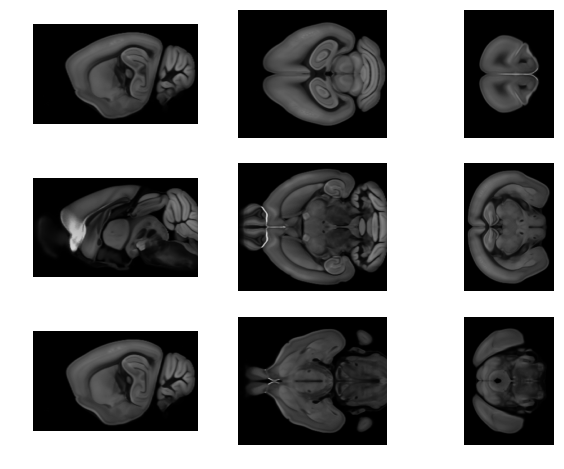

In [31]:
ndreg.imgShow(atlas_rigid)

In [35]:
# whiten the images
whiten_kernel = [5,5,5]
atlas_affine_w = sitk.AdaptiveHistogramEqualization(atlas_rigid, whiten_kernel, alpha=0.25, beta=0.25)
img_bc_w = sitk.AdaptiveHistogramEqualization(img_bc, whiten_kernel, alpha=0.25, beta=0.25)

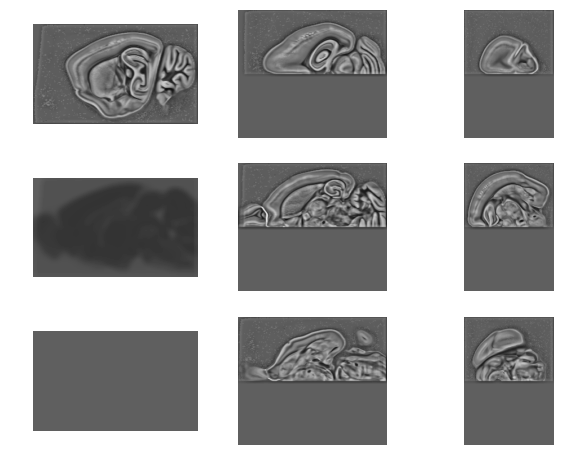

In [36]:
ndreg.imgShow(img_bc_w)

In [37]:
# lddmm code
e = 5e-3
s = 0.1
atlas_lddmm, field, inv_field = register_lddmm(affine_img=sitk.Normalize(atlas_affine_w), 
                                                          target_img=sitk.Normalize(img_bc_w),
                                                          refMask=mask,
                                                          alpha_list=[0.05], 
                                                          scale_list = [0.0625, 0.125, 0.25, 0.5, 1.0],
                                                          epsilon_list=e, sigma=s,
                                                          min_epsilon_list=e*1e-6,
                                                          use_mi=False, iterations=50, verbose=True)


Step 0: alpha=0.05, beta=0.05, scale=0.0625
	E, E_velocity, E_rate, E_image (E_image %), LearningRate
0.	51345.9, 3.25685, 0, 51342.6 (92.9836%), 1.718750e-04
1.	45040.7, 1.17926, 0, 45039.5 (81.5684%), 1.890625e-04
2.	44430.5, 2.11232, 0, 44428.4 (80.4617%), 1.039844e-04
3.	43298.8, 2.53435, 0, 43296.3 (78.4113%), 1.143828e-04
4.	42981.5, 3.28056, 0, 42978.3 (77.8354%), 1.258211e-04
5.	42349.5, 4.13674, 0, 42345.4 (76.6892%), 1.384032e-04
6.	41840.8, 5.19034, 0, 41835.6 (75.766%), 1.522435e-04
7.	41108, 6.44217, 0, 41101.6 (74.4366%), 1.674679e-04
8.	40648.5, 7.96728, 0, 40640.5 (73.6017%), 1.842147e-04
9.	40023.6, 9.77344, 0, 40013.8 (72.4667%), 2.026361e-04
10.	39656.3, 11.9699, 0, 39644.4 (71.7976%), 2.228997e-04
11.	38820.4, 14.5325, 0, 38805.8 (70.279%), 2.451897e-04
12.	38804.6, 15.2838, 0, 38789.3 (70.2491%), 6.742717e-05
13.	38759.6, 16.1143, 0, 38743.5 (70.1661%), 7.416989e-05
14.	38580.1, 17.0454, 0, 38563.1 (69.8393%), 8.158688e-05
15.	38463.1, 18.0914, 0, 38445.1 (69.6256

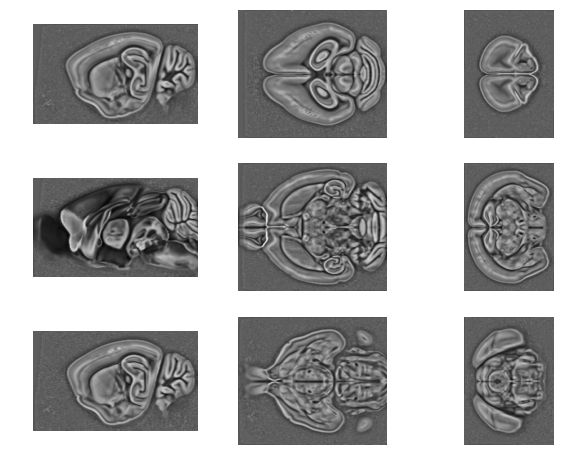

In [38]:
ndreg.imgShow(atlas_lddmm)

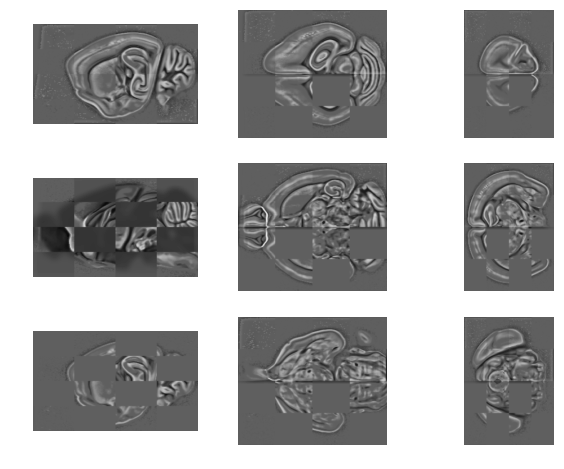

In [39]:
ndreg.imgShow(ndreg.imgChecker(atlas_lddmm, img_bc_w))

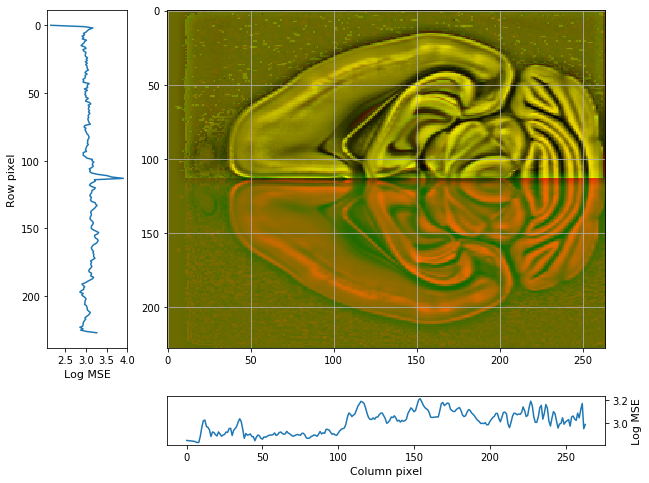

In [45]:
plot_mse(sitk.GetArrayFromImage(sitk.Normalize(atlas_lddmm))[:,50,:], sitk.GetArrayFromImage(sitk.Normalize(img_bc_w))[:,50,:], color_blend=True)


# Method definitions

In [42]:
def register_rigid(atlas, img, learning_rate=1e-2, fixed_mask=None, moving_mask=None, iters=200, min_step=1e-10, shrink_factors=[1], sigmas=[.150], use_mi=False, grad_tol=1e-6, verbose=False):
    """
    Performs affine registration between an atlas an an image given that they have the same spacing.
    """
    registration_method = sitk.ImageRegistrationMethod()

    # Similarity metric settings.
#     registration_method.SetMetricAsMeanSquares()
    if use_mi: registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=128)
    else: registration_method.SetMetricAsMeanSquares()
    # registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
    # registration_method.SetMetricSamplingPercentage(0.01)

    registration_method.SetInterpolator(sitk.sitkBSpline)

    # Optimizer settings.
    registration_method.SetOptimizerAsRegularStepGradientDescent(learningRate=learning_rate,
                                                                 minStep=min_step,
    #                                                              estimateLearningRate=registration_method.EachIteration,
                                                                 gradientMagnitudeTolerance=grad_tol,
                                                                 numberOfIterations=iters)
    registration_method.SetOptimizerScalesFromPhysicalShift()

    # Setup for the multi-resolution framework.            
    registration_method.SetShrinkFactorsPerLevel(shrinkFactors=shrink_factors)
    registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=sigmas)
    registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()
    
    # set the mask
    if moving_mask: 
        registration_method.SetMetricMovingMask(moving_mask)
    if fixed_mask:
        registration_method.SetMetricFixedMask(fixed_mask)

    # initial transform
    # Versor 3d rigid
    initial_transform = sitk.VersorRigid3DTransform()
    length = np.array(atlas.GetSize())*np.array(atlas.GetSpacing())
    initial_transform.SetCenter(length/2.0)

    # Don't optimize in-place, we would possibly like to run this cell multiple times.
    registration_method.SetInitialTransform(initial_transform)


    final_transform = registration_method.Execute(sitk.Cast(img, sitk.sitkFloat32),
                                                  sitk.Cast(atlas, sitk.sitkFloat32))
    return final_transform

In [43]:
def register_lddmm(affine_img, target_img, alpha_list=0.05, scale_list=[0.0625, 0.125, 0.25, 0.5, 1.0], 
                   epsilon_list=1e-4, min_epsilon_list=1e-10, sigma=0.1, use_mi=False, iterations=200, inMask=None,
                   refMask=None, verbose=True, out_dir=''):
    if sigma == None:
        sigma = (0.1/target_img.GetNumberOfPixels())

    (field, invField) = ndreg.imgMetamorphosisComposite(affine_img, target_img,
                                                                                                alphaList=alpha_list,
                                                                                                scaleList=scale_list,
                                                                                                epsilonList=epsilon_list,
                                                                                                minEpsilonList=min_epsilon_list,
                                                                                                sigma=sigma,
                                                                                                useMI=use_mi,
                                                                                                inMask=inMask,
                                                                                                refMask=refMask,
                                                                                                iterations=iterations, 
                                                                                                verbose=verbose,
                                                                                                outDirPath=out_dir)

    source_lddmm = ndreg.imgApplyField(affine_img, field, 
                                            size=target_img.GetSize(), 
                                            spacing=target_img.GetSpacing())
    return source_lddmm, field, invField

In [44]:
import sys, random, ndreg
import numpy as np
import SimpleITK as sitk
import skimage
from ndreg import preprocessor
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

    
def plot_mse(img1, img2, blend=0.2, color_blend=False):
    height, width = img1.shape
    overlap = np.zeros((height, width)) if not color_blend else np.zeros((height, width, 3))
    if not color_blend:
        for i in range(height):
            for j in range(width):
                grey = img1[i,j]*blend + img2[i,j]*blend
                overlap[i,j] = grey
    else:
        img1 = img1 + abs(np.amin(img1))
        img2 = img2 + abs(np.amin(img2))
        img1_max = np.amax(img1)
        img2_max = np.amax(img2)
        for i in range(height):
            for j in range(width):
                overlap[i,j,:] = (img1[i,j]/img1_max, img2[i,j]/img2_max, 0)

    x_errors = []
    for j in range(width):
        error = np.sqrt(np.sum(np.square(img1[:,j] - img2[:,j])))
        x_errors.append(error)
    x_errors = np.log(np.array(x_errors))

    y_errors = []
    for i in range(height):
        error = np.sqrt(np.sum(np.square(img1[i,:] - img2[i,:])))
        y_errors.append(error)
    y_errors = np.log(np.array(y_errors))

    gs = gridspec.GridSpec(5, 5, wspace=0.5, hspace=1)

    ax1 = plt.subplot(gs[:4, 0])
    ax2 = plt.subplot(gs[:4, 1:])
    ax3 = plt.subplot(gs[4, 1:])

    ax1.plot(y_errors, range(height))
    ax1.invert_yaxis()
    ax1.set_xlabel('Log MSE',fontsize=11)
    ax1.set_ylabel('Row pixel', fontsize=11)

    ax3.plot(range(width), x_errors)
    ax3.set_xlabel('Column pixel',fontsize=11)
    ax3.set_ylabel('Log MSE', fontsize=11)
    ax3.yaxis.set_label_position("right")
    ax3.yaxis.tick_right()


    ax2.imshow(overlap, aspect='auto')
    ax2.grid(True)